# **Chap5：注意力机制**

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import jieba
from source.code import ch5
from source.code import ch4
from source.code import utils
from matplotlib import font_manager
font = font_manager.FontProperties(fname="/home/chenguangze/fonts/SimHei.ttf") # 读取中文字体

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **5.3 Transformer**

### **5.3.1 自注意力**

在之前的学习中，对于非结构化数据，我们都是**使用 CNN （主要针对图像），或者 RNN （主要针对序列）对非结构数据进行编码**，将其转换为一个隐藏空间中的特征向量，最后接入**下游网络**，实现我们关心的目标任务

在介绍了注意力机制后，我们可以对词元序列进行**注意力池化**操作，在之前的实现中，我们将 RNN 编码器输出的隐藏状态视为 `key` 和 `value`，将解码器的输入视为 `query`，在**解码器中使用了注意力池化**，自然地，人们思考在**编码器中能否也使用注意力机制**？

无论是 CNN，RNN 还是注意力池化，这些**算子的目的都是抽取和加工非结构化输入中的有效特征**，一种扩宽注意力机制使用范围的思想是，**将输入** $X$ **同时充当** `query`, `key` **和** `value`
  * 具体来说，每个 `query` 都会关注所有作为 `key-value` 对的其他输入，然后产生一个注意力池化输出

由于 `key`，`value` 都来自同一组输入，因此该方法称为**自注意力**（**Self-Attention**）

我们通过表达式形式化自注意力过程，给定一个词元输入序列 $x_1,x_2,\cdots,x_n$，其中 $x_i\in\mathbb{R}^d, i=1,\cdots,n$，则**自注意力池化将输入的** $n$ **个元素转换为** $n$ **个输出** $y_1,\cdots,y_n$：

$$
y_i = f\left( q,(k_1,v_1),\cdots,(k_n,v_n) \right) = f\left( x_i,(x_1,x_1),\cdots,(x_n,x_n) \right)\in\mathbb{R}^d,\quad i=1,\cdots,n
$$

我们直接通过上一节定义的**多头注意力**来演示自注意力

In [4]:
# 隐藏单元大小，多头数量
num_hiddens, num_heads = 100, 5 # 注意要让 num_heads 整除 num_hiddens
# 实例化多头注意力
attention = ch5.MultiHeadAttention(num_hiddens, num_heads, dropout=0.5)

# 生成输入特征 X
X = tf.ones((2, 4, num_hiddens)) # 形状为：(batch_size, n_q, num_hiddens)
valid_lens = tf.constant([3, 1])

# 将 X 同时作为 queries, keys, values，查看输出形状
attention(queries=X, keys=X, values=X, valid_lens=valid_lens).shape

TensorShape([2, 4, 100])

下面，我们**比较 CNN，RNN 和自注意力特征提取时的并行度**

### **5.3.1.1 比较 CNN、RNN 和自注意力**

假设我们现在要处理一个由 $n$ 个词元组成的序列，**目标是将该序列映射到另一个长度相等的隐藏空间中的序列**，输入和输出词元都是 $d$ 维向量

<img src="./source/Chap5/比较CNN.svg" width=800>

**(1) 卷积神经网络**

虽然我们只介绍了二维卷积来处理图像这种二维输入，但**卷积算子很容易能扩展到一维或更高维度**，例如考虑一个卷积核大小为 $1\times k$ 的卷积层，这相当于考虑一维卷积（**将二维图片拉直后，也可以看作宽度只有 1 个单位的序列**），它将**在长度为** $n$ **的序列上滑动**，然后按照卷积的计算过程提取特征

由于序列长度是 $n$，输入和输出的通道数量都是 $d$（特征维度），所以**该卷积层的计算复杂度为** $\mathcal{O}(knd^2)$
* 如上图所示，由于 CNN 是分层的，从上一层输入到下一层输出，**每个输出的计算互不干扰，可以并行处理**，我们说**有** $\mathcal{O}(1)$ **个顺序操作可以并行计算**
* 此外，词元间相互传递信息的**最大路径为** $\mathcal{O}(n/k)$（即需要 $\mathcal{O}(n/k)$ 层卷积），例如输入词元 $x_1,x_5$ 之间的信息交换发生在第二层，**它们处于卷积核大小** $k=3$ **的第二层卷积输出的感受野内**

**(2) 循环神经网络**

当更新循环神经网络的隐状态时，$d\times d$ 的权重矩阵和 $d$ 维隐状态的乘法计算复杂度为 $\mathcal{O}(d^2)$，由于序列长度是 $n$，因此**循环神经网络的计算复杂度为** $\mathcal{O}(nd^2)$
* 如上图所示，循环神经网络下一步的计算依赖于上一步，**有** $\mathcal{O}(n)$ **个顺序操作无法并行**，这是**循环神经网络训练速度缓慢的核心原因**
* 此外，循环神经网络**最大路径为** $\mathcal{O}(n)$，词元 $x_1$ 和 $x_n$ 的想要相互传递信息，**必须经过一条长度为** $n$ **的更新链**，在某种程度上会**限制模型的长序列学习能力**（即长期记忆）

**(3) 自注意力**

在自注意力中，`query`. `key` 和 `value` 都是 $n\times d$ 矩阵，如果使用**缩放点积注意力**，则核心计算包括 $n\times d$ 矩阵和 $d\times n$ 矩阵乘法（**得到** $n\times n$ **的注意力权重**），输出再进行一次 $n\times n$ 矩阵和 $n\times d$ 矩阵的乘法（**对** `value` **加权求和得到输出**），因此**自注意力的计算复杂度为** $\mathcal{O}(n^2d)$
* 如上图所示，在自注意力中，**序列中每个词元都可以通过自注意力连接到其它任何词元**
* 自注意力与 CNN 一样，**有** $\mathcal{O}(1)$ **个顺序操作可以并行**，因为序列中不同位置的输出没有依赖关系
* 自注意力的最大优势是**最大路径为** $\mathcal{O}(1)$，词元间**信息相互传递的效率极高**

简单总结，自注意力机制的提出带来了两大优势：
* **自注意力和 CNN 都拥有并行计算的优势**
* **自注意力的最大路径长度最短**，信息传递效率高

但需要注意，**自注意力其计算复杂度是关于序列长度的二次方**，所以**在很长的序列中计算会非常慢**

### **5.3.2 位置编码**

在正式将自注意力应用到处理词元序列时，我们需要解决一个**逻辑信息缺失**的问题

在处理词元序列时，**RNN 是逐个的重复地处理词元的**，而**自注意力则因为并行计算而放弃了顺序操作**
* 这**丢弃了序列中包含的顺序信息**，意味着我们**随机打乱序列中词元的排列顺序，对自注意力的计算没有影响**，这显然是不合理的

为了加入序列的顺序信息，人们在输入表示中添加**位置编码**（**Positional Embedding**）来**注入绝对的或相对的位置信息**

**位置编码可以通过学习得到**也可以**直接固定**，下面介绍**基于正弦函数和余弦函数的固定位置编码**

假设输入 $X\in\mathbb{R}^{n\times d}$，包含一个序列中 $n$ 个词元的 $d$ 维嵌入表示（**Embedding 后的向量表示**），位置编码使用相同形状的位置嵌入矩阵 $P\in\mathbb{R}^{n\times d}$，得到输出 $X+P$，其中，矩阵第 $i$ 行，第 $2j,2j+1$ 列上的元素被设置为：
$$
P_{i,2j} = \sin\left(\frac{i}{10000^{2j/d}}\right), \quad P_{i,2j+1} = \cos\left(\frac{i}{10000^{2j/d}}\right)

$$

下面的 `PositionalEmbedding` 类实现了上述的固定位置编码

In [8]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_hiddens : int, max_len : int=1000, dropout : float=0,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        # 创建一个足够长的位置编码矩阵 P
        # P 故意多增加了一维，这作为批量维度使用
        # 这样可以直接与形状为 (batch_size, n_q, num_hiddens) 的张量通过广播机制相加
        self.P = np.zeros((1, max_len, num_hiddens))
        # 生成 i / 10000^(2j / num_hiddens) 的矩阵
        # 这里先把 i 通过 reshape(-1,1) 变成列向量，再利用广播机制就可以得到
        X = np.arange(max_len, dtype=np.float32).reshape(-1, 1)\
            / np.power(10000, np.arange(0, num_hiddens, 2) / num_hiddens)
        self.P[:,:,0::2] = np.sin(X) # 偶数列用 sin
        self.P[:,:,1::2] = np.cos(X) # 奇数列用 cos
    
    def call(self, X : tf.Tensor, *args, **kwargs):
        # X 的形状为 (batch_size, n_q, num_hiddens)
        # 通过广播机制将 P 与 X 相加
        # 不需要将 P 用完，只需要使用到前 n_q 行，因为只要对 n_q 长的序列做位置编码
        X = X + self.P[:, :X.shape[1], :]
        return self.dropout(X,**kwargs)

在位置矩阵 $P$ 中，**行代表词元在序列中的位置，列代表对不同特征维度的位置编码**
* 下图可以看到，**随着特征列数的增加，所施加的位置编码信号的频率降低**

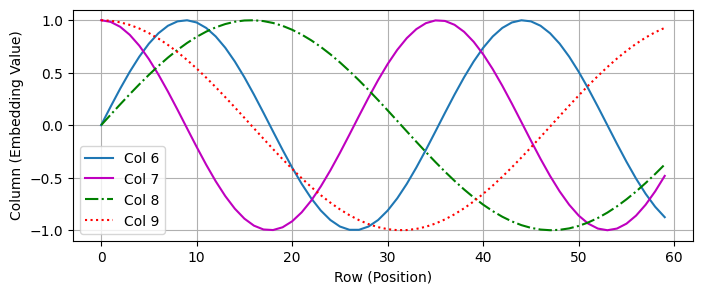

In [19]:
# 实例化位置编码层
pos_embed = PositionalEmbedding(num_hiddens=32)
X = pos_embed(tf.zeros((1, 60, 32))) # X 的形状为 (batch_size, n_q, num_hiddens)
P = pos_embed.P[:, :X.shape[1], :] # P 的形状为 (1, n_q, num_hiddens)
# 可视化位置编码
fig = plt.figure(figsize=(8, 3))
lines = ["-", "m-", "g-.", "r:"]
for i,t in enumerate(range(6,10)):
    plt.plot(np.arange(60), P[0,:,t], lines[i], label=f'Col {t}')
plt.xlabel("Row (Position)")
plt.ylabel("Column (Embedding Value)")
plt.grid()
plt.legend()

要理解这种正弦余弦的编码特点，我们可以**观察一下数据 0~7 的二进制表示**
* 从**二进制的最低位到最高位（从右到左）**，每个数字、每两个数字和每四个数字上的**比特值交替**，**交替频率越来越慢**
* 在二进制表示中，**较高比特位的交替频率低于较低比特位**

In [21]:
for i in range(8):
    print(f'{i} 的二进制是：{i:>03b}')

0 的二进制是：000
1 的二进制是：001
2 的二进制是：010
3 的二进制是：011
4 的二进制是：100
5 的二进制是：101
6 的二进制是：110
7 的二进制是：111


**位置编码通过使用三角函数在编码维度上降低频率**，实现与二进制编码相似的效果
* 位置编码**输出是浮点数**，因此**这种连续编码表示比二进制表示法更节省空间**

位置编码除了能像二进制编码一样**编码序列的绝对位置信息**，它还**允许模型学习得到输入序列的相对位置信息**

**对于任何确定的位置偏移** $\delta$，**位置** $i+\delta$ **的位置编码可以线性投影到位置** $i$ **处的位置编码表示**，令 $\omega_j = 1 / 10000^{2j/d}$，对于任何给定的偏移 $\delta$，编码 $(p_{i,2j},p_{i,2j+1})$ 都可以线性投影到 $(p_{i+\delta,2j},p_{i+\delta,2j+1})$：

$$
\begin{split}\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=&
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}\end{split}
$$

上面的推导中，**投影算子对应的矩阵只和偏移量** $\delta$ **有关**，而与任何序列的位置索引 $i$ 无关，因此我们称它是一种**相对位置编码**
* 假设词元 $B$ 出现在词元 $A$ 后方 $\delta$ 个词元处，则无论 $A,B$ 出现在序列中的哪个位置，**只要词元** $A,B$ **的相对位置不变，我们就能用相同的投影矩阵来捕获它们之间的关系**

追后我们补充说明，**位置编码直接将编码矩阵** $P$ **加到输入** $X$ **上**：
* 因此，自注意力在处理序列的位置信息时，**与 RNN 不同，模型并不对位置信息建模**
* 传递位置信息 $P$ 时，我们并没有采用拼接 concat 操作，而是直接将 $X,P$ 相加
    * 优点：**不会带来额外的维度扩张，减少模型复杂度**
    * 我们**希望模型能够捕获输入上微小的扰动** $P$，**以识别位置信息**，但这对模型特征提取的能力提出了更高的要求

### **5.3.3 纯注意力网络：Transformer**

在 **5.3.1节** 中，我们介绍了自注意力，以及自注意力的两大优势：
* **与 CNN 一样可并行**
* **信息传递的最大路径为** $\mathcal{O}(1)$

自注意力设计深度学习模型非常吸引人，2017年，Vaswani 等人**提出了一个完全基于注意力的机制的深度学习模型 Transformer**，不包含任何卷积层和循环神经网络层，Transformer最初是**应用于在文本数据上的序列到序列学习**（例如机器翻译），但现在已经**成为各种现代深度学习模型的基础骨干网络**

#### **5.3.3.1 模型结构**

Transformer是一种**编码器-解码器**架构的实例，结构如下图所示，**Transformer的编码器和解码器是基于注意力的模块叠加而成的**，源（输入）序列和目标（输出）序列的**词元嵌入表示（Embedding 输出）**将加上**位置编码（Positional Embedding）**，再分别输入到编码器和解码器中

<img src="./source/Chap5/transformer.svg" width=600>

我们先简单了解Transformer的结构和一些模块，后面再逐步实现
* **Transformer的编码器是由多个相同的自注意力池化层叠加而成的**，每个层都**有两个子层**
    * 第一个子层是**多头自注意力池化**
    * 第二个子层是**基于位置的前馈网络**

    自注意力计算中，`query`，`key` 和 `value` 都**来自于前一个编码器曾的输出**，受 `ResNet` 的启示，**每个子层都使用了残差跳连**
    * 在 Transformer 中，序列中任何位置的输入 $x\in\mathbb{R}^d$，在经过任何一个子层 $\text{sublayer}$ 后都满足 $\text{sublayer}(x)\in\mathbb{R}^d$，**以便进行残差跳连**
    * 残差跳连后，需要进行**层归一化**（**Layer Normalization**），这是一钟类似于 BatchNorm 的归一化操作，作用效果相同，但原理略有差别
    * 最后 **Transformer编码器 将输出每个词元的** $d$ **维表示**

* **Transformer的解码器也是由多个相同的注意力池化层叠加而成的**，这些层也都**使用了残差跳连和层归一化**
    * 除了编码器介绍的两个子层（**多头自注意力池化**，**基于位置的前馈网络**），解码器还在两个层之间插入了**编码器-解码器注意力层**，在该层钟，来自解码器前一层的输出作为 `query`，**来自整个编码器的输出作为** `key`, `value`，因此，在 Transformer 解码器钟，整个编码器的输出将作为 `key-value` 被多次使用
    * 在**解码器的自注意力池化**中，`query`，`key`，`value` 都**来自上一层解码器的输出**
    * 需要注意，**解码器中的每个位置只能考虑该位置之前的所有位置**（不能预先看到未来信息，词元需要一个接一个预测），因此我们需要**使用掩蔽注意力**（**Masked Attention**），以保留这种“自回归”属性，确保预测仅依赖已经生成的词元

下面介绍**基于位置的前馈网络**和**层归一化**两个基础模块

#### **5.3.3.2 Transformer 模块**

**(1) 基于位置的前馈网络**

**基于位置的前馈网络**（**PositionWise Feed-Forward Network**，**FFN**）对序列中的所有位置的表示向量进行变换时**使用的是同一个多层感知机**，因此我们说 FFN 是基于位置的，**多层感知机执行的变换与序列中词元的位置无关**

设输入 $X$ 形状为 `(batch_size, num_steps, num_hiddens)`，FFN 用一个两层的的全连接网络将形状变换为 `(batch_size, num_steps, ffn_num_outputs)`

In [24]:
class PositionWiseFFN(tf.keras.layers.Layer):
    def __init__(self, ffn_num_hiddens : int, ffn_num_outputs : int,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens, activation='relu')
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)
    
    def call(self, X : tf.Tensor):
        # X 的形状为 (batch_size, num_steps, num_hiddens)
        # 两个全连接层变换仅在最后一维上进行，因此变换与位置无关
        return self.dense2(self.dense1(X))

在使用时，我们可以**先改变 FNN 内里层输出单元的维度，再将其恢复到原来的维度**
* 因为**所有时间位置使用相同的变换**，我们设置输入在所有时间步上取相同的值，那么输出结果在所有时间步上也相同
* 如果要在 Transformer 中将**多层堆叠**，**FFN 应该控制输出维度和输入维度相同**

In [30]:
# 实例化 FFN 层
ffn = PositionWiseFFN(ffn_num_hiddens=4, ffn_num_outputs=8)
ffn(tf.ones((1, 3, 4)))

<tf.Tensor: shape=(1, 3, 8), dtype=float32, numpy=
array([[[ 0.5616127 ,  0.7571864 , -0.006459  , -0.1734156 ,
          0.14325243,  0.21846125, -0.08973956,  0.19665748],
        [ 0.5616127 ,  0.7571864 , -0.006459  , -0.1734156 ,
          0.14325243,  0.21846125, -0.08973956,  0.19665748],
        [ 0.5616127 ,  0.7571864 , -0.006459  , -0.1734156 ,
          0.14325243,  0.21846125, -0.08973956,  0.19665748]]],
      dtype=float32)>

**(2) 残差跳连和层归一化 LayerNorm**

在 `ResNet` 中我们已经看到，**残差连接和归一化操作对成功构建一个深度学习模型非常重要**

BatchNorm 在一个小批量的样本内，**基于批量维度**统计数据各特征 / 通道的均值和标准差实现归一化，**层归一化（LayerNorm）**的目标相同，但 **LayerNorm 是基于特征维度**进行归一化，而不是批量维度
* 尽管 BatchNorm 在 CV 领域被广泛使用，但**在 NLP 中，输入通常是变长序列**，**BatchNorm 处理变长序列时效果一般不如 LayerNorm**

In [31]:
bn = tf.keras.layers.BatchNormalization() # BatchNorm 层
ln = tf.keras.layers.LayerNormalization() # LayerNorm 层

以二维输入 $X$ （批量维度和特征维度，形状`(batch_size, num_hiddens)`）为例：
* `BatchNorm` 使得**每个特征中，各个批量的数值分布零均值，单位方差**
* `LayerNorm` 使得**每个批量中，各个特征的数值分布零均值，单位方差**，在处理变长序列时，每个序列样本会根据自己的数值分布进行归一化，这样在同一个批量中，长短序列互不影响

In [37]:
# 生成输入 X
X = tf.constant([[1, 2], [2, 3]], dtype=tf.float32)
print('LayerNorm:', ln(X,training=True))
print('BatchNorm:', bn(X,training=True))

LayerNorm: tf.Tensor(
[[-0.998006   0.9980061]
 [-0.9980061  0.998006 ]], shape=(2, 2), dtype=float32)
BatchNorm: tf.Tensor(
[[-0.998006   -0.9980061 ]
 [ 0.9980061   0.99800587]], shape=(2, 2), dtype=float32)


接下来我们实现 `AddNorm` 类，它**包含了残差跳连和 LayerNorm 操作**

In [34]:
class AddNorm(tf.keras.layers.Layer):
    def __init__(self, norm_shape, dropout : float=0,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(norm_shape)
    
    def call(self, X : tf.Tensor, Y : tf.Tensor, *args, **kwargs):
        # X 和 Y 的形状一样，均为 (batch_size, num_steps, num_hiddens)
        return self.ln(self.dropout(Y, **kwargs) + X)

`AddNorm` 中**残差连接要求** $X,Y$ **具有相同的形状**，最后输出的结果也和 $X$ 的形状相同

In [36]:
# 实例化
# 针对维度 [2]，特征维度进行归一化
add_norm = AddNorm(norm_shape=[2],dropout=0.5)
X = tf.ones((2,3,4)) # 形状为 (batch_size, num_steps, num_hiddens)
add_norm(X=X,Y=X, training=False).shape

TensorShape([2, 3, 4])

#### **5.3.3.3 Transformer 编码器**

有了组成 Transformer 所需的基本结构，我们首先来实现**编码器**，编码器是由多个相同的 `Block` 堆叠而成，我们先定义 `EncoderBlock`，它包含编码器的两个子层：**多头自注意力池化** 和 **基于位置的前馈网络**

In [3]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, num_hiddens : int, norm_shape, ffn_num_hiddens : int,
                 num_heads : int, dropout : float=0, use_bias : bool=False,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        # 子层一：多头自注意力
        self.attention = ch5.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = ch5.AddNorm(norm_shape, dropout)
        # 子层二：基于位置的前馈网络
        self.ffn = ch5.PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = ch5.AddNorm(norm_shape, dropout)
    
    def call(self, X : tf.Tensor, valid_lens, *args, **kwargs):
        # 做多头自注意力池化时，query、key、value 都是 X
        # 然后做 AddNorm
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, **kwargs), **kwargs)
        # 经过前馈网络后，再做 AddNorm
        return self.addnorm2(Y, self.ffn(Y), **kwargs)

从实现中可以看到，**Transformer编码器中的任何层都不会改变其输入的形状**

In [8]:
num_hiddens = 32
X = tf.ones((2, 10, num_hiddens)) # 形状为 (batch_size, num_steps = n_q, num_hiddens)
valid_lens = tf.constant([3, 2])
norm_shape = [2]
encoder_blk = EncoderBlock(num_hiddens, norm_shape, ffn_num_hiddens=48, num_heads=8, dropout=0.5)
encoder_blk(X, valid_lens, training=False).shape

TensorShape([2, 10, 32])

接下来，只需要将 `EncoderBlock` 堆叠 `num_layers` 层，并且让前一层的输出作为下一层的输入，就可以得到 Transformer编码器，在处理最开始的输入词元 $X$，我们还需要做额外的**词嵌入**和**位置编码**工作

In [5]:
class TransformerEncoder(utils.Encoder):
    def __init__(self, vocab_size : int, num_hiddens : int, norm_shape, ffn_num_hiddens : int, 
                 num_heads : int, num_layers : int, dropout : float=0, use_bias : bool=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_embedding = ch5.PositionalEmbedding(num_hiddens, dropout=dropout)
        # 创建 num_layers 个 Block
        self.blocks = [
            ch5.EncoderBlock(num_hiddens, norm_shape, ffn_num_hiddens, num_heads, dropout, use_bias)
            for _ in range(num_layers)]
    
    def call(self, X : tf.Tensor, valid_lens, *args, **kwargs):
        # 先进行词嵌入，因为位置编码的值在 [-1,1] 之间
        # 因此嵌入向量先乘以嵌入维度的平方根进行一次缩放，然后再与位置编码相加
        X = self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, tf.float32)) # 缩放
        X = self.pos_embedding(X, **kwargs) # 位置编码

        # 初始化注意力权重
        self.attn_weights = [None] * self.num_layers
        for i,block in enumerate(self.blocks):
            # 逐层计算，并添加到注意力权重列表中
            X = block(X, valid_lens, **kwargs)
            self.attn_weights[i] = block.attention.attention.attn_weights
        
        return X

`EncoderBlock` 和 `TransformerEncoder` 已经写入 `./source/code/ch5.py`，Transformer编码器的输出形状是 `(batch_size, num_steps=n_q, num_hiddens)`

In [6]:
# 实例化编码器
encoder = TransformerEncoder(
    vocab_size=100, num_hiddens=32, norm_shape=[2], 
    ffn_num_hiddens=48, num_heads=8, num_layers=2, dropout=0.5)
# 生成输入原始词元输入 X
X = tf.ones((2, 10)) # 形状为 (batch_size, num_steps = n_q)
valid_lens = tf.constant([3, 2]) 
encoder(X, valid_lens, training=False).shape # 形状为 (batch_size, num_steps=n_q, num_hiddens)

TensorShape([2, 10, 32])

#### **5.3.3.4 Transformer 解码器**

**Transformer解码器** 也是由多个相同的层组成。在 `DecoderBlock` 类中包含了三个子层：**解码器自注意力**、“**编码器-解码器**”**注意力** 和 **基于位置的前馈网络**
* 在第一个多头自注意力子层中，我们需要**使用掩蔽注意力**，在训练阶段，其输出序列的**所有时间步的词元都是已知的**，然而，在预测阶段，其**输出序列的词元是逐个生成的**
* 因此，**在任何解码器时间步** $t'$，**只有生成的词元** $y_1,y_2,\cdots,y_{t'}$ **才能用于解码器的自注意力的计算**，在注意力的计算中添加 `dec_valid_lens` 做**掩蔽注意力**，保留了解码器的这种**自回归属性**

此外，我们为 `DecoderBlock` 设置了一个属性变量 `index` 以**标识这是第几个编码器块**

In [9]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, num_hiddens : int, norm_shape, ffn_num_hiddens : int,
                 num_heads : int, index : int, dropout : float=0, use_bias : bool=False,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.index = index
        # 子层一：多头自注意力
        self.attention1 = ch5.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = ch5.AddNorm(norm_shape, dropout)
        # 子层二：编码器-解码器多头注意力
        self.attention2 = ch5.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm2 = ch5.AddNorm(norm_shape, dropout)
        # 子层三：基于位置的前馈网络
        self.ffn = ch5.PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = ch5.AddNorm(norm_shape, dropout)
        
    def call(self, X : tf.Tensor, state, *args, **kwargs):
        enc_outputs, enc_valid_lens = state[0], state[1] # state 包含了 enc_outputs 和 enc_valid_lens
        # 训练阶段，输出序列的所有词元都在同一时间处理
        # state[2][self.index] 初始化为 None
        # 预测阶段，输出序列是通过词元一个接一个预测得到
        # state[2][self.index] 包含着直到当前时间步的解码器第 index 个 Block 的输出表示
        if state[2][self.index] is None:
            key_values = X # 训练阶段，一次性可以拿到所有时间步的词元
        else:
            # 预测阶段。不断地将之前时间步累计的输出表示与 X 进行拼接
            # 每拼接一次，可以进行自注意力计算的 num_steps + 1
            key_values = tf.concat((state[2][self.index], X), axis=1)
        state[2][self.index] = key_values

        # 训练阶段
        if kwargs["training"]:
            batch_size, num_steps, _ = X.shape
            # 解码器有效长度 dec_valid_lens 维度 (batch_size, num_steps)
            # 其中每一行的元素为 [1, 2, ..., num_steps]
            # 这用于进行掩蔽注意力
            dec_valid_lens = tf.repeat(tf.reshape(tf.range(1, num_steps + 1), shape=(-1, num_steps)), 
                                       repeats=batch_size, axis=0)
        else:
            dec_valid_lens = None
        
        # 子层一：多头自注意力
        # 将 dec_valid_lens 作为掩盖，时间步 t' 的词元只会和之前的词元计算注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens, **kwargs)
        Y = self.addnorm1(X, X2, **kwargs)
        # 子层二：编码器-解码器多头注意力
        # enc_outputs 的形状为 (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, **kwargs)
        Z = self.addnorm2(Y, Y2, **kwargs)
        # 子层三：基于位置的前馈网络
        # 返回解码器的输出，和更新后的 state
        return self.addnorm3(Z, self.ffn(Z), **kwargs), state

为了在 Transformer解码器 的**编码器-解码器注意力**中使用**缩放点积注意力**，编码器和解码器应该有相同的特征维度 `num_hiddens`

In [5]:
# 实例化
num_hiddens, norm_shape = 32, [2]
encoder_blk = ch5.EncoderBlock(num_hiddens, norm_shape, ffn_num_hiddens=48, num_heads=8, dropout=0.5)
decoder_blk = ch5.DecoderBlock(num_hiddens, norm_shape, ffn_num_hiddens=48, num_heads=8, dropout=0.5, index=0)

# 生成随机输入
X = tf.ones((2, 10, num_hiddens)) # 形状为 (batch_size, num_steps=n_q, num_hiddens)
enc_valid_lens = tf.constant([3, 2])
# 初始化 state，包含三个元素，分别为 enc_outputs, enc_valid_lens, dec_state
state = [encoder_blk(X, valid_lens, training=False), enc_valid_lens, [None]]
# 输出形状为 (batch_size, num_steps, num_hiddens)
decoder_blk(X, state, training=False)[0].shape

TensorShape([2, 10, 32])

接下来将 `num_layers` 层 `DecoderBlock` 堆叠就得到了 **Transformer解码器**
* 最后一层输出通过一个全连接层和 `Softmax` 得到输出词元的概率分布
* 我们可以保存**解码器自注意力**和**编码器-解码器注意力**的注意力权重
* 注意在 Transformer 中，编码器和解码器不需要有相同的层数 `num_layers`

In [7]:
class TransformerDecoder(utils.Decoder):
    def __init__(self, vocab_size : int, num_hiddens : int, norm_shape, ffn_num_hiddens : int,
                 num_heads : int, num_layers : int, dropout : float=0, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        # 嵌入层和位置编码
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = ch5.PositionalEmbedding(num_hiddens, dropout=dropout)
        # 创建 num_layers 个 Block
        self.blocks = []
        for i in range(num_layers):
            self.blocks.append(
                ch5.DecoderBlock(num_hiddens, norm_shape, ffn_num_hiddens, num_heads, index=i, dropout=dropout))
        # 输出层
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # 初始化解码器所需的隐藏状态 state
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def call(self, X : tf.Tensor, state, **kwargs):
        # 先进行词嵌入和位置编码
        X = self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, dtype=tf.float32))
        X = self.pos_encoding(X, **kwargs)

        # 初始化注意力权重，解码器包含有两种注意力
        # 子层一是多头自注意力，子层二是编码器-解码器多头注意力
        self._attn_weights = [[None] * len(self.blocks) for _ in range(2)]
        for i, block in enumerate(self.blocks):
            # 逐层计算，并添加到注意力权重列表中
            # 同时更新隐藏状态
            X, state = block(X, state, **kwargs)
            self._attn_weights[0][i] = block.attention1.attention.attn_weights
            self._attn_weights[1][i] = block.attention2.attention.attn_weights
        
        Y = tf.nn.softmax(self.dense(X)) # 输出层，并转换为概率分布
        return Y, state
    
    # 获取注意力权重
    @property
    def attention_weights(self):
        return self._attn_weights

`DecoderBlock` 和 `TransformerDecoder` 已经写入 `./source/code/ch5.py`，我们来测试一下函数接口工作是否正常

In [4]:
# 实例化
num_hiddens, norm_shape = 32, [2]
encoder = ch5.TransformerEncoder(vocab_size=100, num_hiddens=num_hiddens, norm_shape=norm_shape, 
                                 ffn_num_hiddens=48, num_heads=8, num_layers=2, dropout=0.5)
decoder = ch5.TransformerDecoder(vocab_size=100, num_hiddens=num_hiddens, norm_shape=norm_shape, 
                                 ffn_num_hiddens=48, num_heads=8, num_layers=2, dropout=0.5)

# 生成随机输入
X = tf.ones((2, 10)) # 形状为 (batch_size, num_steps=n_q)
enc_valid_lens = tf.constant([3, 2])
# 初始化 state
enc_outputs = encoder(X, enc_valid_lens, training=False)
state = decoder.init_state(enc_outputs, enc_valid_lens)
# 输出形状为 (batch_size, num_steps, vocab_size)
decoder(X, state, training=False)[0].shape

TensorShape([2, 10, 100])

#### **5.3.3.5 Transformer 机器翻译**

我们以**机器翻译**任务为例，演示 Transformer模型 的训练
* 我们设定 `num_hiddens = 64`，`ffn_num_hiddens = 128`
* 注意力均使用 `num_heads = 4`，编码器和解码器堆叠 `num_layers = 2` 层

In [3]:
# 创建编码器解码器模型
num_hiddens, ffn_num_hiddens, dropout = 64, 128, 0.20
num_heads, num_layers = 4, 2
norm_shape = [2]
batch_size, num_steps = 1024, 15

# 读取数据
train_iter, src_vocab, tgt_vocab = ch4.load_translation_en_zh(
    file="./source/data/translation/news_v16-en-zh.tsv",
    batch_size=batch_size, num_steps=num_steps)

# 创建编码器-解码器模型
encoder = ch5.TransformerEncoder(vocab_size=len(src_vocab), num_hiddens=num_hiddens, norm_shape=norm_shape, 
                                 ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, num_layers=num_layers, dropout=dropout)
decoder = ch5.TransformerDecoder(vocab_size=len(tgt_vocab), num_hiddens=num_hiddens, norm_shape=norm_shape, 
                                 ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, num_layers=num_layers, dropout=dropout)
transformer = utils.EncoderDecoder(encoder, decoder)

  0%|          | 0/322275 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.559 seconds.
Prefix dict has been built successfully.
100%|██████████| 322275/322275 [01:30<00:00, 3580.48it/s]
2023-05-03 00:55:17.049228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 00:55:17.642025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


平均 1539793.3 词元/秒


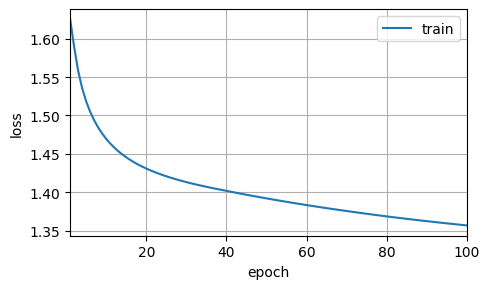

In [4]:
transformer = utils.train_seq2seq(transformer, train_iter, tgt_vocab, Epochs=100, lr=0.005)

In [5]:
# 保存模型
# transformer.save_weights("./source/model/transformer_translation_en_zh.h5")

我们来测试一下 Transformer 模型的预测效果

In [14]:
# 句子对
pairs = [["it seems that i won the game !", "我似乎赢得了比赛！",],
         ["i know this book .", "我知道这本书。",],
         ["how are you today ?", "今天你如何？",]]
# 评估模型
for en, zh in pairs:
    trans, dec_attn_weights = utils.predict_seq2seq(
        transformer, en, src_vocab, tgt_vocab, num_steps=15, num_preds=10, save_attention_weights=True)
    # 计算 BLEU
    bleu = utils.chinese_bleu(zh, trans, k=2)
    print(f"{en} \n=> {trans}, bleu {bleu:.3f}")

it seems that i won the game ! 
=> 我似乎赢得比赛！, bleu 0.762
i know this book . 
=> 我知道这本书。, bleu 1.000
how are you today ? 
=> 今天你如何？, bleu 1.000


Transformer 相比基于 RNN 的编码器-解码器架构提升明显，翻译的正确性提高了很多
* 在语句中，几乎**每个词元都能够被正确翻译**
* 还可以发现，**语句翻译更加自然，一些需要前置翻译的词元被正确转达**，例如 `how are you today ?` 中，处于末尾的词元 `today` 被首先翻译，这是符合语义的

接下来，我们绘制 Transformer 中的注意力分布，它们分别是**编码器自注意力**，**解码器自注意力**和**编码器-解码器注意力**

需要注意，**模型每次处理不同的语句，其注意力权重都会发生改变**
* 因此下面的注意力权重，我们以翻译语句 `it seems that i won the game !` 为例

In [66]:
# 确定翻译目标，让模型推理一遍
en = "it seems that i won the game !"
num_steps = 15
trans, dec_attn_weights = utils.predict_seq2seq(
    transformer, en, src_vocab, tgt_vocab, num_steps=num_steps, num_preds=10, save_attention_weights=True)
trans_tokens = list(jieba.cut(trans))

**(1) 编码器的注意力权重**

编码器的自注意力权重保存在 `model.encoder.attn_weights` 中
* 它包含了**源语句中，每个词元在通过自注意力机制提取特征时，注意力权重的分布情况**

In [54]:
encoder_attn_weights = tf.concat(transformer.encoder.attn_weights, axis=0)
encoder_attn_weights = tf.reshape(encoder_attn_weights, (num_layers, num_heads, -1, num_steps))
encoder_attn_weights.shape

TensorShape([2, 4, 15, 15])

从下面的注意力权重分布图可以观察到：
* 每一行代表不同层的注意力权重，总共 `num_layers` 层，**不同的层，不同的注意力头，所进行的注意力池化有变化**
* 由于源语句 `it seems that i won the game !` 的有效长度 `valid_lens = 9` （加上最后的 `<eos>`），而我们设定了 `num_steps = 15` 的填充，所以**超过** `valid_lens` **的部分不会被分配任何注意力**
* 对于语句 `it seems that i won the game !`，可以观察到**大部分注意力头的权重分布呈现从左上到右下的对角线**，这说明**每个词元的核心特征抽取来自于自身**，即大部分注意力头**把每个词元的注意力分配给自己**
* 当然也会出现像**第一层，Head 3**这样的**反向注意力**，第一个词元 `it` 作为 `query` 时抽取末尾词元的特征

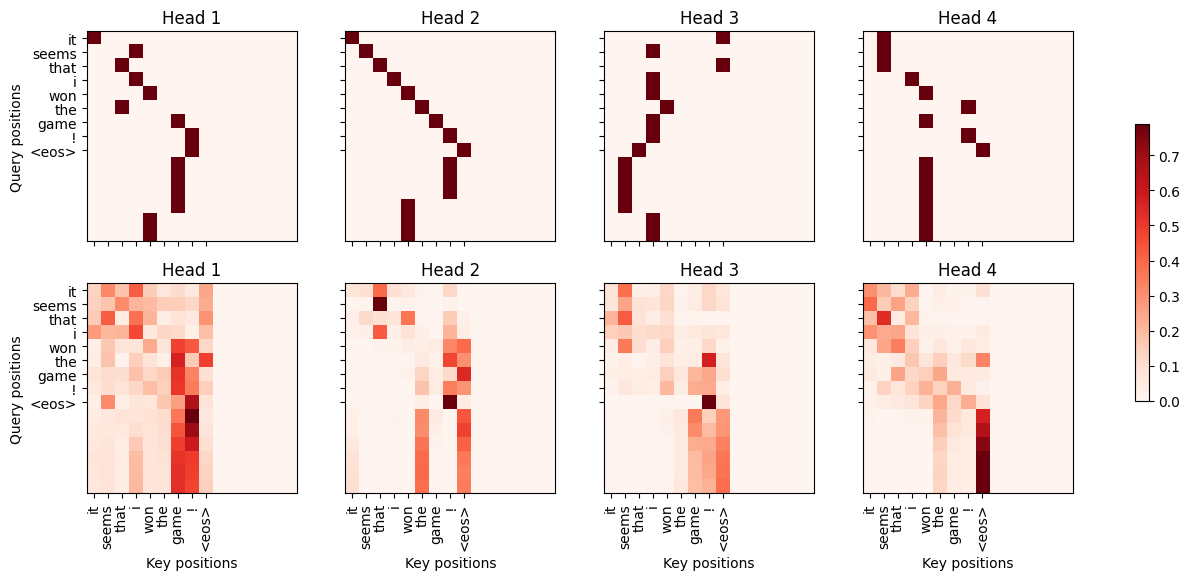

In [92]:
ax = utils.show_attention(encoder_attn_weights, xlabel='Key positions', ylabel='Query positions',
                          titles=['Head %d' % i for i in range(1, 5)], figsize=(16, 6))
# 添加坐标轴刻度
ax = ax.flatten()
for i in range(8):
    ax[i].set_xticks(range(len(en.split()) + 1))
    ax[i].set_xticklabels(en.split() + ["<eos>"], rotation=90)
    ax[i].set_yticks(range(len(en.split()) + 1))
    ax[i].set_yticklabels(en.split() + ["<eos>"])

**(2) 解码器的注意力权重**

为了可视化解码器中保存的注意力权重，我们需要先对预测函数输出 `dec_attn_weights` 稍作处理，下面的函数 `fetch_dec_attn_weights` 已经写入 `./source/code/ch5.py`

In [95]:
def fetch_dec_attn_weights(dec_attn_weights, num_layers : int, num_heads : int, num_steps : int):
    dec_attention_weights_tmp = []
    # 依次拿出每一个预测时间步
    for step in dec_attn_weights:
        # 依次拿出每一种注意力，共有两种
        # 解码器的多头自注意力，编码器-解码器的多头注意力
        for attn in step:
            # 依次取出每一层的注意力权重
            for attn_layer in attn:
                # 依次取出每一个头的注意力权重
                for head in attn_layer:
                    # head 形状：(1, num_steps)
                    dec_attention_weights_tmp.append(head[0])
    # 由于随着推理进行，每个 head 的 num_steps 会逐渐增加
    # 借助 Pandas 的 DataFrame，可以很方便地将不同长度的注意力权重填充到同一个表格中
    # 长度不够的部分会自动用 NaN 填充，然后我们用 fillna(0) 将 NaN 替换为 0
    dec_attention_weights_tmp = tf.constant(
        (pd.DataFrame(dec_attention_weights_tmp).fillna(0).values).astype(np.float32))

    # 变换形状，拆分为 (-1, 2, num_layers, num_heads, num_steps)
    # -1 表示模型预测输出的词元长度 num_preds
    # 2 表示两种注意力，解码器自注意力 和 编码器-解码器注意力
    dec_attention_weights_tmp = tf.reshape(dec_attention_weights_tmp, (-1, 2, num_layers, num_heads, num_steps))
    # 用 transpose 改变轴排列为 (2, num_layers, num_heads, num_preds, num_steps)
    dec_attention_weights_tmp = tf.transpose(dec_attention_weights_tmp, (1, 2, 3, 0, 4))

    # 分别取出解码器自注意力 和 编码器-解码器注意力
    dec_self_attn_weights, enc_dec_attn_weights = dec_attention_weights_tmp[0], dec_attention_weights_tmp[1]

    return dec_self_attn_weights, enc_dec_attn_weights

In [96]:
dec_self_attn_weights, enc_dec_attn_weights =\
    fetch_dec_attn_weights(dec_attn_weights, num_layers, num_heads, num_steps)

**解码器自注意力的具有自回归属性**，通过掩蔽的操作，`query` **不会对当前位置之后的** `key-value` **对进行注意力计算**（即不会超过左上右下对角线）

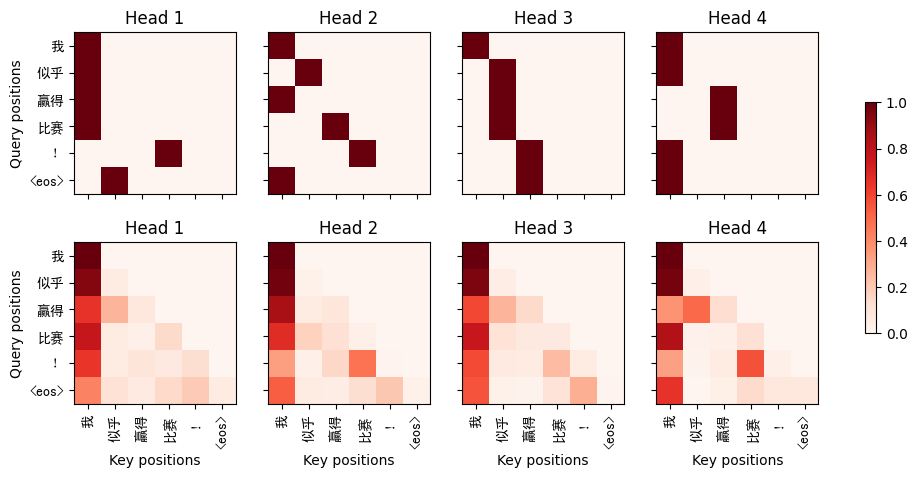

In [94]:
# 绘制解码器自注意力权重
ax = utils.show_attention(dec_self_attn_weights[:,:,:,:len(trans_tokens)+1], 
                          xlabel='Key positions', ylabel='Query positions',
                          titles=['Head %d' % i for i in range(1, 5)], figsize=(12, 5))
# 添加坐标轴刻度
ax = ax.flatten()
for i in range(8):
    ax[i].set_xticks(range(len(trans_tokens) + 1))
    ax[i].set_xticklabels(trans_tokens + ["<eos>"],fontproperties=font, rotation=90)
    ax[i].set_yticks(range(len(trans_tokens) + 1))
    ax[i].set_yticklabels(trans_tokens + ["<eos>"],fontproperties=font)

我们来看更有意思的**编码器-解码器注意力**
* **与编码器的自注意力的类似**，通过**指定输入序列的有效长度**，输出序列的 `query` **不会与源语句中的填充词元进行注意力计算**
* 观察**第一个输出词元** `我` 的翻译，源语句 `it seems that i won the game !` 中相同含义的词元 `i` 出现在**中间位置**，在预测 `我` 时，**多个头的注意力都集中到了源语句中的词元** `i` **上**
* 对于机器翻译任务，**输出语句中的注意力移动大部分情况下还是呈现左上到右下的趋势**，这符合语句翻译的特点

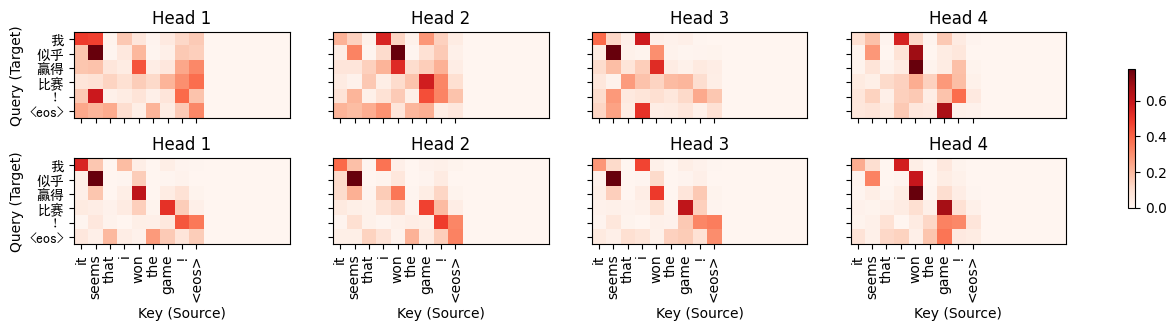

In [85]:
# 绘制解码器自注意力权重
ax = utils.show_attention(enc_dec_attn_weights, 
                          xlabel='Key (Source)', ylabel='Query (Target)',
                          titles=['Head %d' % i for i in range(1, 5)], figsize=(16, 3))
# 添加坐标轴刻度
ax = ax.flatten()
for i in range(8):
    ax[i].set_xticks(range(len(en.split()) + 1))
    ax[i].set_xticklabels(en.split() + ["<eos>"], rotation=90)
    ax[i].set_yticks(range(len(trans_tokens) + 1))
    ax[i].set_yticklabels(trans_tokens + ["<eos>"],fontproperties=font)

----

### **练习**

1. 我们在本节介绍的是**固定位置编码**方法，事实上，位置编码也可以作为模型参数在训练中学习，你可以设计一种可以学习的位置编码方法，或者查阅资料，了解现有的**可学习的位置编码方案**

2. 下面的问题有助于你回顾和加深对 Transformer 和注意力机制的理解
    1. 在实验中，分别讨论增加 `num_layers`，`num_hiddens`，`num_steps` 如何影响模型训练的速度
    2. 在 Transformer 中，**将缩放点积注意力更换为加性注意力是不是个好办法**？为什么？
    3. 如果我们要解决文本序列的预测问题，即给定上文，预测下文（**RNN 中第一节的语言模型任务**），**应该使用 Transformer 的编码器还是解码器**？**还是两者都用**？你会如何设计？
    4. 如果**输入的序列很长**（`num_steps` 很大），Transformer 会面临什么挑战？为什么？
    5. 总结 Transformer 的优点
    6. 有关 Transformer 的改进工作，包括计算效率、内存使用效率等，可以阅读论文 [Efficient Transformers: A Survey](https://arxiv.org/abs/2009.06732)

3. Transformer 这种纯注意力网络的出现替代了 RNN 处理序列这种非结构数据的特征提取任务，如果**不使用 CNN，设想一下应该如何将 Transformer 和注意力机制应用到图像分类任务呢**

----